<b><font size = '2' face='Verdana'>r/AwesomeReports</font></b> <font size='2' face='Verdana' color='darkgray'>$\bullet$ Posted by u/EmergingDataScientist 12 hours ago</font>
<br>
<br>
# Theme Extraction by Unraveling Clusters of Reddit Post Titles
MSDS 2020 - Data Mining and Wrangling

# Executive Summary
*Reddit* is one of the most popular social media websites that allows users to submit and rate content such as links, text posts, images, GIFs, videos, etc. which may be from a variety of topics including news, science, movies, or food, posted by members organized by subject into boards called *subreddits*. This study aims to *identify the subreddits or themes* from a sample of *6000 post titles* from the file `reddit-dmw-sample.txt` using two types of *clustering* methods such as representative-based (*$k$-means*) and hierarchical (*Ward's agglomerative* method) clustering.

Depending on the clustering method used, the number of clusters ($k$) recommended differed. This is because of their different approach and tests used to determine $k$. For representative-based, 7 clusters were made, while there are 10 for hierarchical. Although different, resulting themes were quite similar. The following themes were extracted: *general inquires (advice), US presidential elections (Trump, Clinton, and Sanders), New Year (2016), gaming (video and online), food, speeding ticket, tech support, and vine compilations*.

# Table of Contents
* Data Description and Processing
* Exploratory Data Analysis
* Models
* Results and Recommendations
* References and Acknowledgements

# Data Description and Processing
    
A sample of 6,000 Reddit post titles, commonly known as *subreddits*, were provided in a form of a TXT file: `reddit-dmw-sample.txt`.

It has two columns: author (with which some are deleted/not provided), and title (subreddit posts).



The file is only 500KB in size so opening it using `Notepad++` was possible. Upon checking, data has headers in the first line and are separated by *tab*.


With this, we can easily load the data using `pandas`:

In [1]:
import pandas as pd
reddit = pd.read_csv('reddit-dmw-sample.txt', sep='\t', index_col=0)
display(reddit.head())
print('File has', len(reddit), 'titles.')

,author,title
0,PrimotechInc,7 Interesting Hidden Features of apple ios9
1,xvagabondx,Need an advice on gaming laptop
2,nkindustries,Semi automatic ROPP Capping machine / ROPP Cap...
3,Philo1927,Microsoft Plumbs Oceanâ€™s Depths to Test Unde...
4,tuyetnt171,OPPO F1 chÃ­nh hÃ£ng - Fptshop.com.vn


File has 6000 titles.


Since our data are texts, we should first *clean* the data before processing:

In [2]:
# Remove punctuations, convert all to lowercase, strip whitespaces
import re
reddit.title = reddit.title.apply(lambda i: re.sub(
                            r'([^\s\w]|_)+', '', i)).str.lower().str.strip()

In [3]:
# Create a new column with lemmatized titles and the stopwords removed
from wordcloud import STOPWORDS
stopwords = set(STOPWORDS)

from nltk.stem.wordnet import WordNetLemmatizer
lemma = WordNetLemmatizer()

titles_trunc = []
for i, line in enumerate(reddit.title.to_list()):
    word_join = ''
    for word in line.split():
        if word not in list(stopwords):
            word_join += lemma.lemmatize(word) + ' '
    titles_trunc.append(word_join.strip())

reddit['title_trunc'] = titles_trunc

In [4]:
# Drop null, empty, and duplicate titles, if there are any
reddit.dropna()
reddit = reddit[reddit.title_trunc != '']
print('(nulls/empty titles removed) File has', len(reddit), 'titles.')

reddit.drop_duplicates(['title_trunc'], inplace=True)
print('(duplicates removed) File has', len(reddit), 'titles.')

display(reddit.head())

(nulls/empty titles removed) File has 5998 titles.
(duplicates removed) File has 5818 titles.


,author,title,title_trunc
0,PrimotechInc,7 interesting hidden features of apple ios9,7 interesting hidden feature apple ios9
1,xvagabondx,need an advice on gaming laptop,need advice gaming laptop
2,nkindustries,semi automatic ropp capping machine ropp cap ...,semi automatic ropp capping machine ropp cap s...
3,Philo1927,microsoft plumbs oceanâs depths to test underw...,microsoft plumb oceanâs depth test underwater ...
4,tuyetnt171,oppo f1 chãnh hãng fptshopcomvn,oppo f1 chãnh hãng fptshopcomvn


# Exploratory Data Analysis
Before doing anything on our data, let's first explore and look at its properties to have an initial feel of what we are working on.

In [23]:
print('After cleaning, we now have', len(reddit), 'titles.')

After cleaning, we now have 5818 titles.


Let's check the `WordCloud` of the *title_trunc* column:

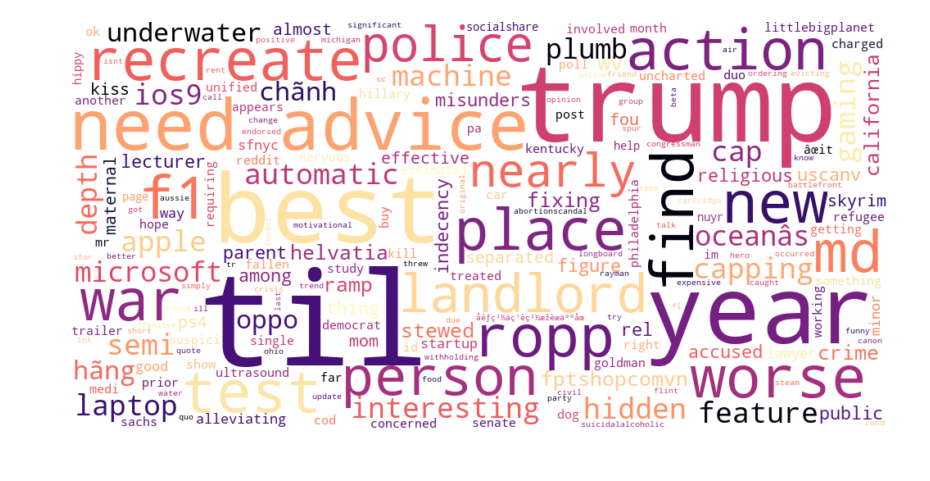

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

# Create the WordCloud from the title_trunc
wordcloud = WordCloud(width=1000, height=500, background_color='white',
            colormap='magma', min_font_size=10).generate(str(reddit.title_trunc))

# Plot the WordCloud image
plt.figure(dpi=150, facecolor=None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

From the figure above, we can already tell a few of the topics:
* *til (today I learned)*: one of the most popular subreddits
* *trump, hillary*: US politicians
* *microsoft, laptop, oppo, ios9*: gadgets/computers/technology

To further see the most frequent words from the title, let's use `Counter`:

In [22]:
from functools import reduce
import operator
from collections import Counter

words = reduce(operator.concat, reddit.title_trunc.str.split().to_list())
words_freq = Counter(words)
print([i[0] for i in words_freq.most_common(30)])

['til', 'new', 'year', 'trump', 'game', 'sander', 'clinton', 'u', 'will', '2016', 'first', 'bernie', 'one', '3', 'state', 'time', 'donald', 'hillary', 'car', 'food', 'best', 'make', 'iowa', 'now', 'need', 'day', 'made', 'help', 'people', 'number']


It seems like a lot of the most frequent words are about politics in the US (*'trump', 'sander', 'clinton', 'state'*), but there are also words like *'new', 'year', 'car', 'food'*, etc. that shows there are more variety of topics. 

Let's proceed with creating the clusters to extract the themes of the titles.

# Models
There are a lot of methods we can use for clustering our data. We would try to use a few of them and see which can produce the most coherent themes.

Let's vectorize the titles so we can perform clustering:

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(token_pattern=r'[a-z0-9-]{3,}', min_df=2, 
                      stop_words='english', ngram_range=(1, 3))

bows = vec.fit_transform(reddit.title_trunc)

## 1. $k$-means clustering

*Representative-based clustering* methods is a family of clustering methods wherein a representative point, which may or may not be a data point, is assigned for each cluster. Data points are then assigned to the nearest representative after which a new representative is selected for the cluster. The alternating steps of assigning points to a cluster and selecting a representative is repeated until it converges.

The simplest and most popular representative-based clustering method is  $k$-means clustering. In this method, the distance function $Dist(\cdot,\cdot)$ is the $L2$-norm or the squared sum error (SSE), which is just the square of the $L2$-norm. The representative is chosen to be the mean of the points in the cluster to minimize the objective function. If the cluster labels of points do not change after a step, then we say the algorithm has converged, *i.e.*, points have been clustered.

We will use $k$-means clustering on the Reddit titles and perform *internal validation* (no external as we don't have a ground truth dataset in this case) through various values of $k$ to group them into the optimal number of clusters. 

### Selecting $k$
Let's first solve for *internal validation* of varying numbers of clusters (*from 2 to 12*):
* sum of squares distances to centroids (inertia)
* Calinski-Harabasz index
* intracluster to intercluster distance ratio
* silhouette coefficient

In [28]:
def intra_to_inter(X, y, dist, r):
    """Compute intracluster to intercluster distance ratio
    
    Parameters
    ----------
    X : array
        Design matrix with each row corresponding to a point
    y : array
        Class label of each point
    dist : callable
        Distance between two points. It should accept two arrays, each 
        corresponding to the coordinates of each point
    r : integer
        Number of pairs to sample
        
    Returns
    -------
    ratio : float
        Intracluster to intercluster distance ratio
    """  
    P = []
    Q = []
    
    np.random.seed(11)

    for i, j in np.random.randint(0, len(X), size=(r, 2)):
        if i == j:
            continue
        elif y[i] == y[j]:
            P.append(dist(X[i], X[j]))
        else:
            Q.append(dist(X[i], X[j]))

    return (np.asarray(P).sum() / len(P)) / (np.asarray(Q).sum() / len(Q))

In [31]:
from scipy.spatial.distance import euclidean
from sklearn.metrics import calinski_harabaz_score, silhouette_score
from sklearn.cluster import KMeans

X = bows.toarray()
chs, iidrs, inertias, scs, amis, ars, ps, ys = [], [], [], [], [], [], [], []
k = ['chs', 'iidrs', 'inertias', 'scs', 'ys']

for i in range(2, 12):
    kmeans = KMeans(n_clusters=i, random_state=1337)
    ys.append(kmeans.fit_predict(X))
    chs.append(calinski_harabaz_score(X, ys[-1]))
    iidrs.append(intra_to_inter(X, ys[-1], euclidean, 50))
    inertias.append(kmeans.inertia_)
    scs.append(silhouette_score(X, ys[-1]))

internal_val = dict(zip(k, [chs, iidrs, inertias, scs, ys]))

Now that we have the *internal validation* results for each $k$, let's plot them to see which is the optimal $k$:

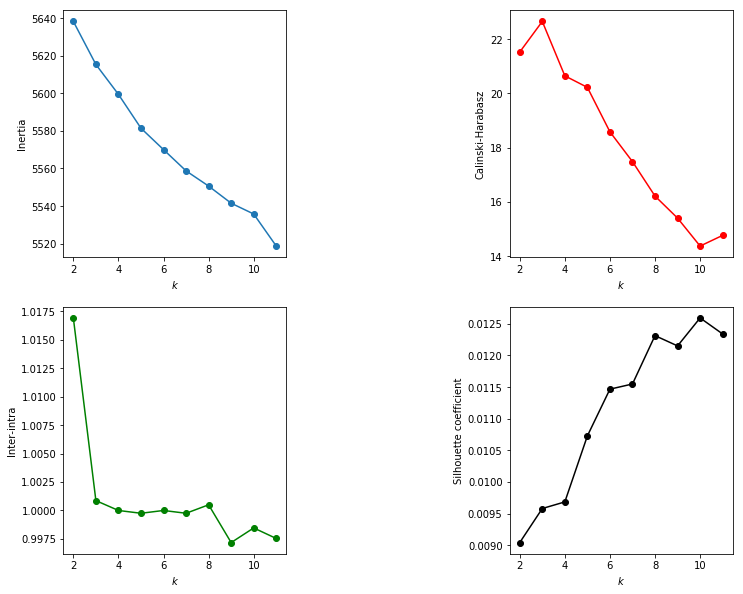

In [50]:
import matplotlib.gridspec as gridspec

inertias = internal_val['inertias']
chs = internal_val['chs']
iidrs = internal_val['iidrs']
scs = internal_val['scs']

ks = np.arange(2, len(inertias)+2)

fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(2, 2)

# Plot inertias
ax1 = plt.subplot(gs[0, 0])
ax1.plot(ks, inertias, '-o')
ax1.set_xlabel('$k$')
ax1.set_ylabel('Inertia')

# Plot Calinski-Harabasz indexes
ax2 = plt.subplot(gs[0, 1])
ax2.plot(ks, chs, '-ro')
ax2.set_xlabel('$k$')
ax2.set_ylabel('Calinski-Harabasz')

# Plot intracluster to intercluster distance ratios
ax3 = plt.subplot(gs[1, 0])
ax3.plot(ks, iidrs, '-go')
ax3.set_xlabel('$k$')
ax3.set_ylabel('Inter-intra')

# Plot silhouette coefficients
ax4 = plt.subplot(gs[1, 1])
ax4.plot(ks, scs, '-ko')
ax4.set_xlabel('$k$')
ax4.set_ylabel('Silhouette coefficient')


fig.subplots_adjust(wspace=1)
fig;

Note that we want to *minimize* the inertia and inter-intra cluster ratio while *maximizing* the Calinski-Harabasz and silhouette coefficient.

With this and based on the plot above (using the *elbow method*), that our optimal $k$ is $10$. We can now perform $k$-means clustering with $k = 10$ and determine each of the clusters and their themes.

In [159]:
kmeans_reddit = KMeans(n_clusters=10, random_state=1337)
y_predict_reddit = kmeans_reddit.fit_predict(bows)

In [160]:
print('Top terms per cluster:\n')

# Sort cluster centers by proximity to centroid
order_centroids = kmeans_reddit.cluster_centers_.argsort()[:, ::-1]
terms = vec.get_feature_names()

for i in range(10):
    print("Cluster_%d words:" % i, end='\n')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end=',')
    print('\n')

Top terms per cluster:

Cluster_0 words:
 million, clinton, til, raised, million dollar, super pac, pac, dollar, george soros, soros,

Cluster_1 words:
 new year, year, new, happy, happy new, happy new year, year eve, new year eve, eve, resolution,

Cluster_2 words:
 clinton, iowa, hillary, hillary clinton, caucus, iowa caucus, email, ops, sander, black,

Cluster_3 words:
 state, home, united state, united, til, law, california, work, job, washington state,

Cluster_4 words:
 game, help, car, 2016, need, recipe, question, best, new, online,

Cluster_5 words:
 til, year, people, world, called, movie, woman, named, day, actually,

Cluster_6 words:
 sander, bernie, bernie sander, campaign, clinton, hillary, sander campaign, hillary clinton, candidate, iowa,

Cluster_7 words:
 trump, donald, donald trump, til donald, til donald trump, clinton, supporter, til, oliver, john oliver,

Cluster_8 words:
 video, 2015, game, video game, gaming, youtube, 2016, year, youtube video, montage,

Cluster

In [161]:
# Create cluster column to reflect the assignment of cluster per title
reddit['cluster'] = kmeans_reddit.fit(bows).labels_
reddit.cluster.unique()

array([4, 5, 2, 6, 9, 7, 3, 1, 8, 0], dtype=int64)

In [162]:
# Determine how many titles are in each cluster

reddit.groupby(['cluster']).count().sort_values(['title'], ascending=False)['title']

cluster
4    4113
5     692
2     227
3     139
6     130
7     128
8     127
1     109
9      93
0      60
Name: title, dtype: int64

Upon checking the titles from each of the 10 clusters (filtered the *reddit dataframe* using *cluster* column), the following are the clustered themes of the reddit titles: <br>
* 4 Combination of gaming, cars, and food <br>
* 5 Mostly TIL posts on various topics on people <br>
* 2 Hillary Clinton's election activities and rivalry with Sanders <br>
* 3 General inquiries on real estate <br>
* 6 Bernie Sanders's election activities and rivalry with Clinton <br>
* 7 Donald Trump's election activities <br>
* 8 Video games <br>
* 1 2016 New Year <br>
* 9 Food <br>
* 0 Topics regarding the word *millions*. Most of which are the amounts spent to or by the US presidential candidates during their campaigns last 2016 elections.

## 2. Ward's method
Ward's method is an agglomerative clustering algorithm. This method defines the distance between two clusters($\Delta$ as the amount of the sum of squares will increase when we merge them. Starting from individual points as a cluster, the method merges them while trying to minimize the growth of $\Delta$. Given two pairs of clusters whose centers are equally far apart, Ward’s method will prefer to merge the smaller ones.

Let's use Ward's method on the Reddit titles to check and compare the clusters (or themes) made with $k$-means clustering. We will select the optimal $k$ based on a visualization (*dendrogram*) of the clustering hierarchy.

In [88]:
from scipy.cluster.hierarchy import linkage, dendrogram

Z = linkage(X, method='ward', optimal_ordering=True)

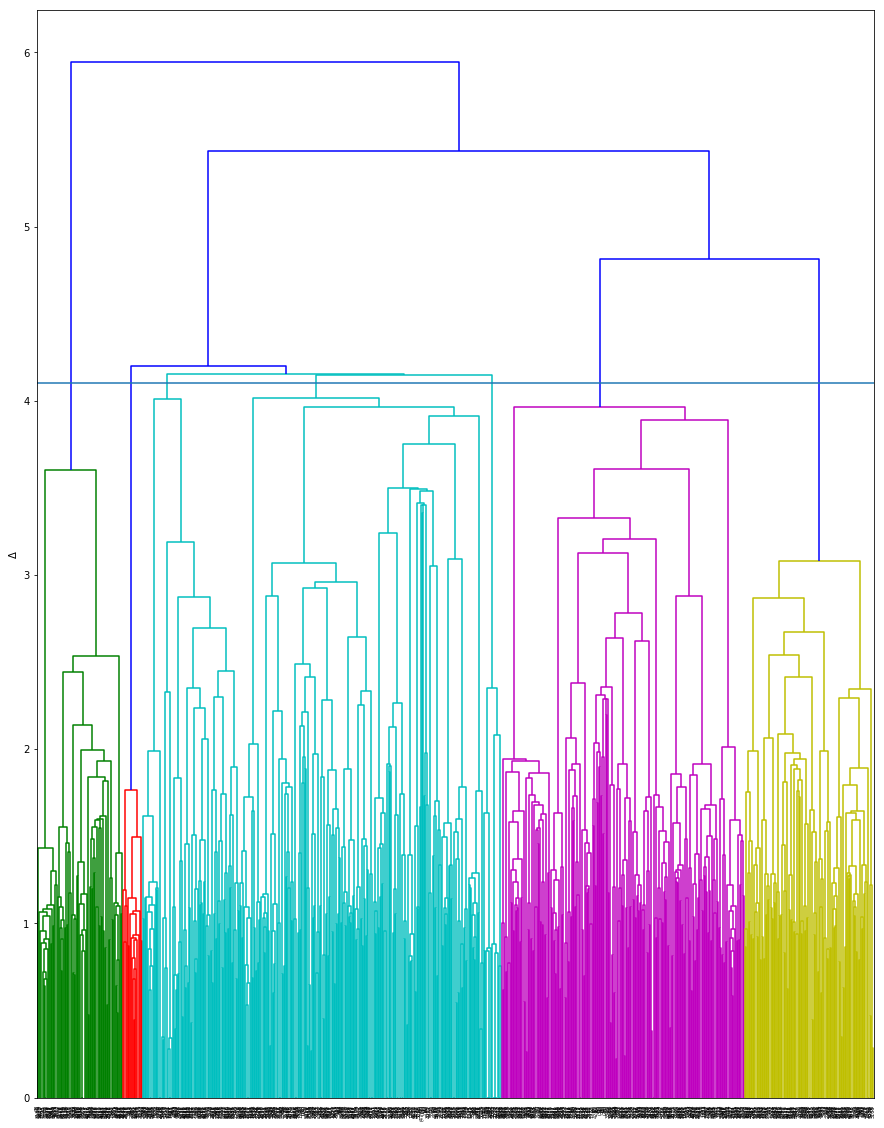

In [126]:
fig, ax = plt.subplots(figsize=(15, 20))
dn = dendrogram(Z, ax=ax, truncate_mode='level', p=15)
ax.set_ylabel(r'$\Delta$')

ax.axhline(y=4.1);

Based from the plot above, we say that $7$ is our optimal $k$. Let's perform agglomerative clustering on the titles.

In [116]:
from sklearn.cluster import AgglomerativeClustering
agg = AgglomerativeClustering(n_clusters=7)

In [117]:
# Create cluster_agg column to reflect the assignment of cluster per title
reddit['cluster_agg'] = agg.fit(X).labels_
reddit.cluster_agg.unique()

array([0, 5, 2, 3, 1, 6, 4], dtype=int64)

Now that we have the 7 clusters, let's use `WordCloud` to visualize each of them.

In [118]:
# Filter dataframe by cluster
cluster_0 = reddit[reddit.cluster_agg==0]
cluster_1 = reddit[reddit.cluster_agg==1]
cluster_2 = reddit[reddit.cluster_agg==2]
cluster_3 = reddit[reddit.cluster_agg==3]
cluster_4 = reddit[reddit.cluster_agg==4]
cluster_5 = reddit[reddit.cluster_agg==5]
cluster_6 = reddit[reddit.cluster_agg==6]

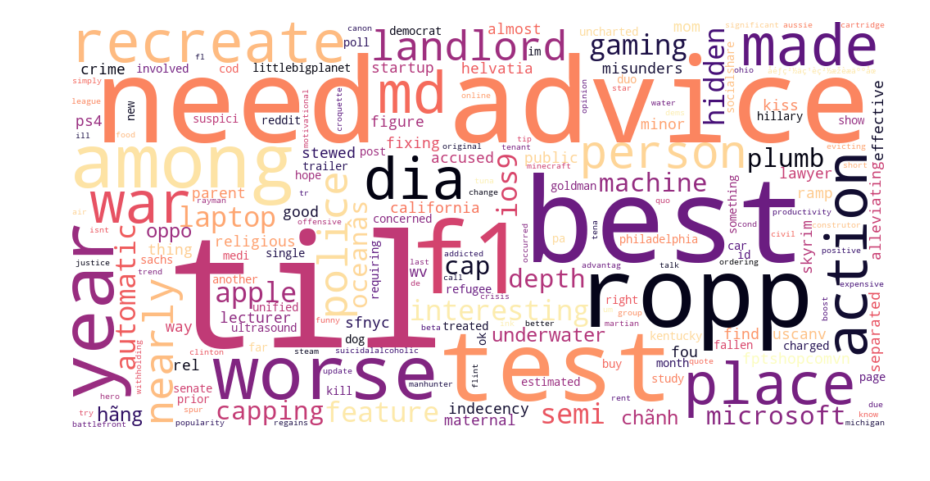

In [119]:
# 1st Cluster
wordcloud = WordCloud(width=1000, height=500, background_color='white',
    colormap='magma', min_font_size=10).generate(str(cluster_0.title_trunc))

# Plot the WordCloud image
plt.figure(dpi=150, facecolor=None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

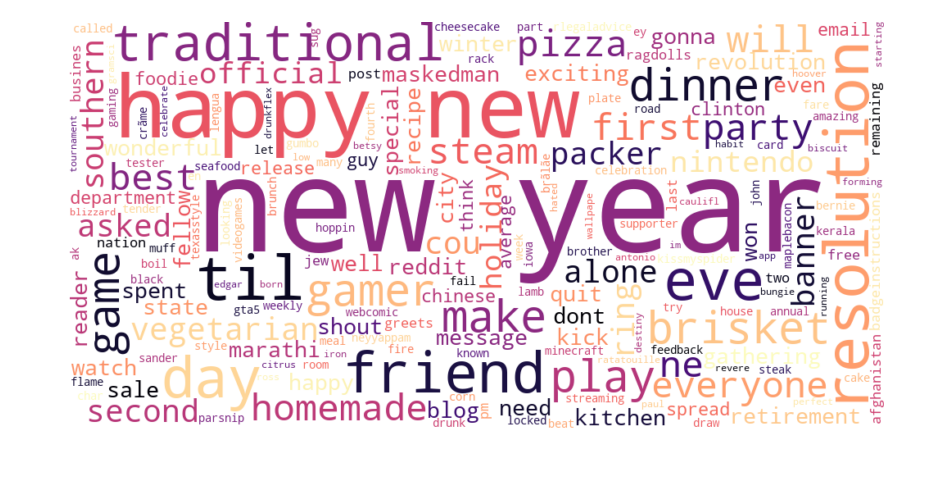

In [120]:
# 2nd Cluster
wordcloud = WordCloud(width=1000, height=500, background_color='white',
    colormap='magma', min_font_size=10).generate(str(cluster_1.title_trunc))

# Plot the WordCloud image
plt.figure(dpi=150, facecolor=None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

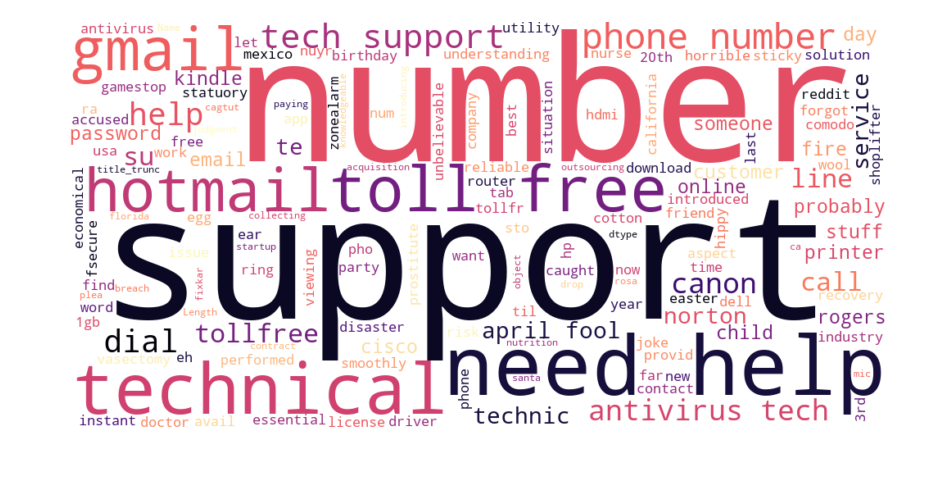

In [121]:
# 3rd Cluster
wordcloud = WordCloud(width=1000, height=500, background_color='white',
    colormap='magma', min_font_size=10).generate(str(cluster_2.title_trunc))

# Plot the WordCloud image
plt.figure(dpi=150, facecolor=None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

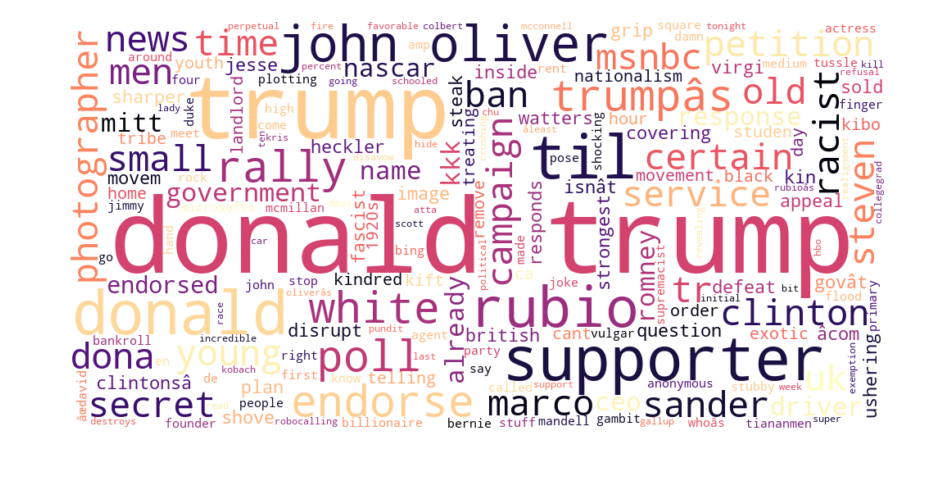

In [122]:
# 4th Cluster
wordcloud = WordCloud(width=1000, height=500, background_color='white',
    colormap='magma', min_font_size=10).generate(str(cluster_3.title_trunc))

# Plot the WordCloud image
plt.figure(dpi=150, facecolor=None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

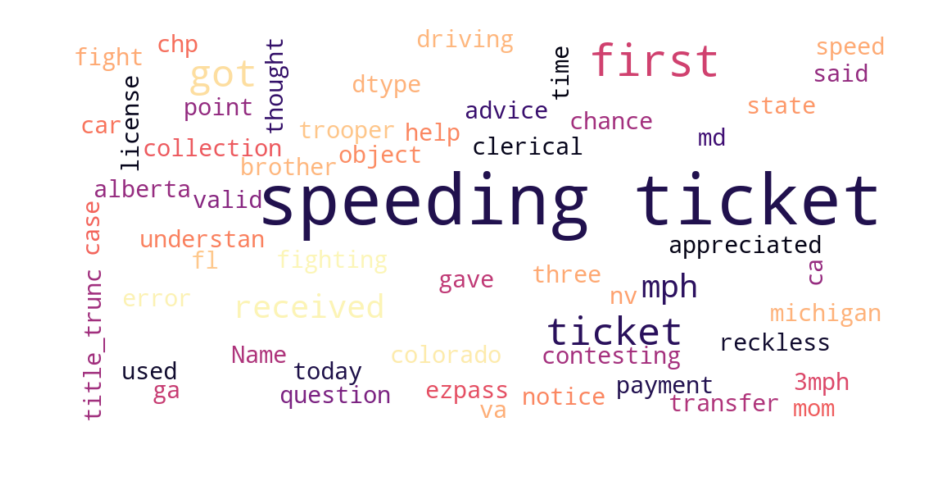

In [123]:
# 5th Cluster
wordcloud = WordCloud(width=1000, height=500, background_color='white',
    colormap='magma', min_font_size=10).generate(str(cluster_4.title_trunc))

# Plot the WordCloud image
plt.figure(dpi=150, facecolor=None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

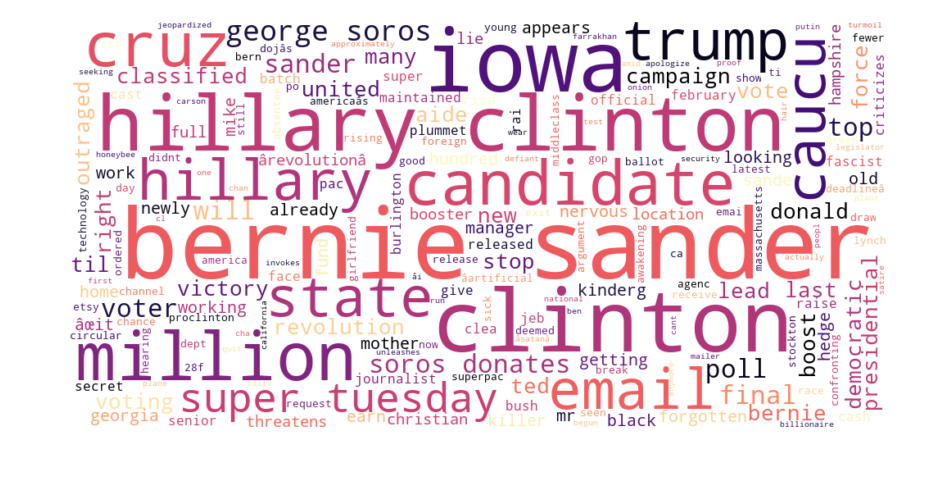

In [124]:
# 6th Cluster
wordcloud = WordCloud(width=1000, height=500, background_color='white',
    colormap='magma', min_font_size=10).generate(str(cluster_5.title_trunc))

# Plot the WordCloud image
plt.figure(dpi=150, facecolor=None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

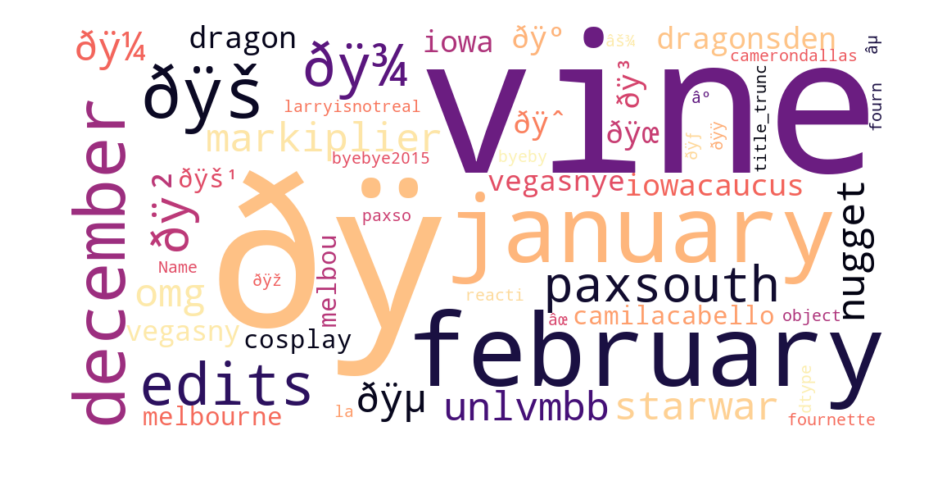

In [125]:
# 7th Cluster
wordcloud = WordCloud(width=1000, height=500, background_color='white',
    colormap='magma', min_font_size=10).generate(str(cluster_6.title_trunc))

# Plot the WordCloud image
plt.figure(dpi=150, facecolor=None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

In [151]:
# Determine how many titles are in each cluster

reddit.groupby(['cluster_agg']).count().sort_values(['title'], ascending=False)['title']

cluster_agg
0    5111
5     349
3     151
2      90
1      82
4      18
6      17
Name: title, dtype: int64

Upon checking the titles from each of the 5 clusters (filtered the *reddit dataframe* using *cluster_agg* column), the following are the clustered themes of the reddit titles (in descending order): <br>
* 0 General inquiries, advice and help on various topics
* 5 Rivalry between Bernie Sanders and Hillary Clinton
* 3 Donald Trump's election activities
* 2 Tech support and customer service
* 1 New Year and New Year's Eve
* 4 Speeding ticket
* 6 Vines compilation

# Results and Recommendations
    
As we saw on the results of both the Representative-based and Hierarchical clustering methods, the recommended number of clusters ($k$) differed. For $k$-means, 7 clusters were made, while there are 10 for Ward's method.

Even though the two clustering methods resulted in different number of clusters, as well as the grouping of the titles, the themes extracted on both of the methods were very similar. This just shows that whatever method we use, both algorithms can provide coherent clusters.

However, note that there are other methods that are deemed to be more appropriate in topic modelling. This is due to the nature of unpredictability and noisiness of text data. Common methods in natural language processing and machine learning are *Latent Dirichlet Allocation* (LDA) and *Non-negative Matrix Factorization* (NMF). The algorithms of these methods take into account the nature of language being processed.

With that, the following themes were extracted from our models: *general inquires (advice), US presidential elections (Trump, Clinton, and Sanders), New Year (2016), gaming (video and online), food, speeding ticket, tech support, and vine compilations* with the *general inquiries* or *TIL* being the most talked about topic.

True enough, TIL is one of the most popular subreddits in the Reddit community wherein members can share any topic with which *they learned* from and users can share advice and discuss inquiries.

# References and Acknowledgements
    
## References:
<a href='https://en.wikipedia.org/'></a>
https://en.wikipedia.org/ <br>
http://brandonrose.org/clustering <br>
https://appliedmachinelearning.blog/2018/01/18/conventional-approach-to-text-classification-clustering-using-k-nearest-neighbor-k-means-python-implementation/ <br>
MSDS 2019: DMW-Project-Alba-Colipapa- Clustering <br>
MSDS 2019: DMW-Final-Project-SLT8A


## Acknowledgements:
MSDS 2019's Alba and Colipapa, Mendoza and Manasan <br>
MSDS 2020, especially my LT-mates <br>
AIM MSDS Faculty and Staff <br>
Prof. Eduardo David <br>
Prof. Christian Alis <br>
Prof. Erika Legara <br>
ACCeSs Lab <br>